<a href="https://colab.research.google.com/github/niltontac/EspAnalise-EngDados/blob/master/MedicalAppointmentNoShows_ModelosDeClassificacao_PCA_GB_TREE_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Medical Appointment No-shows
#Aplicando Modelos de Classificação

###Importando Bibliotecas

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

###Carregando dataset

In [31]:
data = pd.read_csv('https://raw.githubusercontent.com/niltontac/EspAnalise-EngDados/master/data/KaggleV2-May-2016.csv')
data

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2.572134e+12,5651768,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3.596266e+12,5650093,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,1.557663e+13,5630692,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,9.213493e+13,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No


###Análise exploratória dos dados

####Tratando e enriquecendo os dados

In [32]:
# Dimensões do dataset (linhas x colunas)
data.shape

(110527, 14)

In [33]:
# Informações do dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [34]:
# Descrição resumida do dataset incluíndo tendência central, dispersão e distribuição
data.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [35]:
# Consultando se há dados ausentes ou nulos
print(data.isnull().sum())
print(data.isna().sum())

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64
PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64


In [36]:
# Consultando a distribuição dos registros de classe do atributo alvo - 'No-show'

# Transformando os valores 'No' e 'Yes' da coluna 'No-show' para '0' e '1' respectivamente
data_num = data.copy()

data_num = data_num.rename(columns={'No-show': 'Noshow'})
y = data_num['Noshow']
y.replace('No', 0, inplace=True)
y.replace('Yes', 1, inplace=True)

yes = len(data_num[data_num.Noshow==1])
no = len(data_num[data_num.Noshow==0])

print(yes, 'registros classificados como "Yes"')
print(no, 'registros classificados como "No"')

22319 registros classificados como "Yes"
88208 registros classificados como "No"


In [37]:
# Consultando a quantidade de instâncias por gênero
data_num['Gender'].value_counts()

F    71840
M    38687
Name: Gender, dtype: int64

In [38]:
# Função para converter os valores String das instâncias do atributo 'Gender' para valores numéricos 
def converter_genero(valor):
  if valor == 'F':
    return 0
  else:
    return 1

# Criando uma nova coluna ('GenderBin') para gênero com os valores numéricos
data_num['GenderBin'] = data['Gender'].map(converter_genero)

# Excluíndo a coluna 'Gender'
data_num.drop('Gender', axis=1, inplace=True)

In [39]:
# Setando a coluna 'Neighbourhood' como dados categóricos
data_num['Neighbourhood'] = data_num.Neighbourhood.astype('category')

# Transformando os atributos String de 'Neighbourhood' em códigos
data_num['Neighbourhood'] = data_num['Neighbourhood'].cat.codes

In [40]:
# Visualizando primeiros registros do dataset
data_num.head()

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Noshow,GenderBin
0,2.987250e+13,5642903,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,39,0,1,0,0,0,0,0,0
1,5.589978e+14,5642503,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,39,0,0,0,0,0,0,0,1
2,4.262962e+12,5642549,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,45,0,0,0,0,0,0,0,0
3,8.679512e+11,5642828,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,54,0,0,0,0,0,0,0,0
4,8.841186e+12,5642494,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,39,0,1,1,0,0,0,0,0


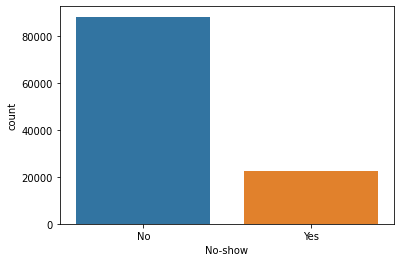

In [41]:
# Visualizando a distribuição dos registros de classe do atributo alvo

sns.countplot(data['No-show'])

O gráfico acima nos mostra que há um desbalanceamento do atributo alvo (coluna 'No-show'), onde há bem menos registros classificados como "Yes".

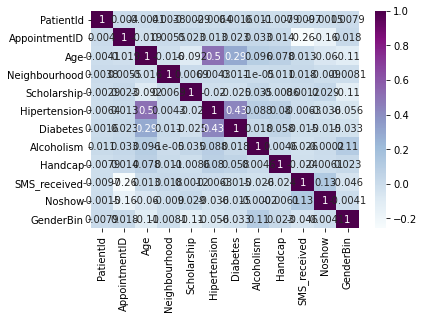

In [42]:
# Visualizando a correlação entre todos atributos e o atributo alvo("Noshow")

sns.heatmap(data_num.corr(), annot=True, cmap='BuPu')

Este gráfico de correlação ajuda a entender melhor o grau de importância/influência entre os atributos. Por exemplo, existe uma forte influência positiva entre o atributo preditor 'Age' com o atributo alvo 'Noshow'. Também há uma forte influência positiva entre os atributos 'Diabetes' e 'Hipertension'.

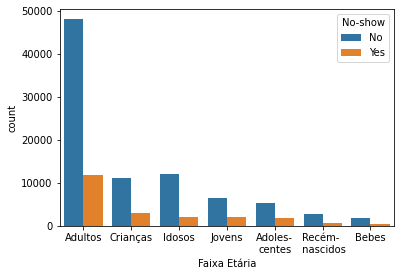

In [43]:
# Gráfico de barras para visualizar a influência de comparecimentos ou não ('No-show') em relação a idade ('Age')

def faixaEtaria (x):
    if x >=0 and x < 1 : return 'Recém- \n nascidos'
    elif x >=1 and x < 2 : return 'Bebes'
    elif x >=2 and x < 12 : return 'Crianças'
    elif x >=12 and x < 18 : return 'Adoles-\ncentes'
    elif x >=18 and x < 24 : return 'Jovens'
    elif x >=24 and x < 65 : return 'Adultos'
    else: return 'Idosos'

data['Faixa Etária']= data['Age'].apply(faixaEtaria)
sns.countplot(x="Faixa Etária", hue = "No-show", data=data)

Como observado no gráfico de correlação, existe uma influência positiva significativa entre o atributo preditor 'Age' e o atributo alvo 'No-show'. 
Então, é interessante mostrar através do gráfico de barras acima como se dá essa influência criando faixas etárias onde fica claro a proporção de comparecimentos e não comparecimentos as consultas nos registros da base. Observe que foram denominadas várias faixas etárias. 
Por meio dessas faixas, é bem claro que a faixa denominada de 'Adultos' (entre 24 e 65 anos) tem uma quantidade significativa de não comparecimentos.

In [44]:
# Função para comparar a probabilidade de variáveis

def probStatusVariable(variable):
  rows=[]
  for i in variable:
    for prob in data_num[i].unique():
      row = {'Doença': i}
      total = len(data_num[data_num[i] == prob])
      z = len(data_num[(data_num[i] == prob) & (data_num.Noshow == 0)])
      row.update({'Indice': prob, 'Probabilidade': z/total})
      rows.append(row) 
  return pd.DataFrame(rows)

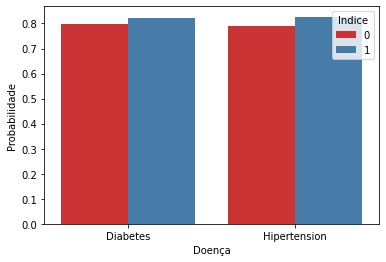

In [45]:
# Gráfico de barras para visualizar a influência de comparecimentos ou não ('No-show') em relação
# aos atributos preditores 'Diabetes' e 'Hipertension'

sns.barplot(data = probStatusVariable(['Diabetes', 'Hipertension']),
            x='Doença', y='Probabilidade', hue='Indice', palette='Set1')
plt.ylabel('Probabilidade')
plt.show()

O gráfico de barras acima evidencia a forte correlação positiva entre os atributos preditores 'Diabetes' e 'Hipertension'. As barras vermelhas representam os pacientes que não tem diabetes ou hipertensão. Já as barras azuis representam os pacientes que tem uma ou a outra doença. 
O que esse gráfico nos mostra é que ambas as doenças tem forte probabilidade em fazer com que os pacientes compareçam as consultas, e também  mostra que independe os pacientes terem ou não diabetes ou hipertensão, comprovando a influência entre esses atributos.

###Selecionando 3 modelos de classificação para avaliação e comparação

In [46]:
# Modelos classificadores selecionados
clf_rf = RandomForestClassifier(n_estimators=300) # RANDOM FOREST definido com estimativa de 300 amostras de treinamento
clf_tree = DecisionTreeClassifier(criterion='entropy') # DECISION TREE definido com função de entropy para medir qualidade da divisão da árvore 
clf_gb = GradientBoostingClassifier(n_estimators=300) # GRADIENT BOOSTING definido com estimativa de 300 amostras de treinamento

print(clf_rf)
print(clf_tree)
print(clf_gb)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
GradientBoostingClassif

###Dividindo o dataset em treino e teste

In [47]:
# Criando matriz para X e y
X = data_num.drop(['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay', 'Neighbourhood', 'Scholarship', 'Handcap', 'SMS_received', 'Noshow'], axis=1).values
y = data_num['Noshow'].values

print('--> Array de X:\n', X, '\n')

print('--> Array de y:\n', y)

--> Array de X:
 [[62  1  0  0  0]
 [56  0  0  0  1]
 [62  0  0  0  0]
 ...
 [21  0  0  0  0]
 [38  0  0  0  0]
 [54  0  0  0  0]] 

--> Array de y:
 [0 0 0 ... 0 0 0]


In [48]:
# Dados de X e y para treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print('Conjunto de treino com {} instâncias'.format(X_train.shape[0]))
print('Conjunto de teste com {} instâncias'.format(X_test.shape[0]))

Conjunto de treino com 88421 instâncias
Conjunto de teste com 22106 instâncias


In [49]:
# Treinamento dos dados pelo modelos classificadores
clf_rf.fit(X_train, y_train)
clf_tree.fit(X_train, y_train)
clf_gb.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

###Treinando os modelos de classificação

In [50]:
# Criando uma lista para calcular as métricas de accuracy, precision, recall e f1_macro
scoring_list = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

scores_rf = cross_validate(clf_rf, X, y, cv=5, scoring=scoring_list)
scores_tree = cross_validate(clf_tree, X, y, cv=5, scoring=scoring_list)
scores_gb = cross_validate(clf_gb, X, y, cv=5, scoring=scoring_list)

avg_scores_rf = []
avg_scores_tree = []
avg_scores_gb = []

for score in scoring_list:
  avg_scores_rf.append(scores_rf['test_'+score].mean())
  avg_scores_tree.append(scores_tree['test_'+score].mean())
  avg_scores_gb.append(scores_gb['test_'+score].mean())

print('RANDOM FOREST - ', avg_scores_rf)
print('TREE - ', avg_scores_tree)
print('GRADIENT BOOSTING - ', avg_scores_gb)

RANDOM FOREST -  [0.7968007875033973, 0.5419852543584689, 0.500645543884245, 0.4472063585790423]
TREE -  [0.7971988801135889, 0.5466343067447808, 0.5005268151323486, 0.4463810149122449]
GRADIENT BOOSTING -  [0.7980131546481652, 0.5440417238257155, 0.5000496540332316, 0.4440515496189211]


###Comparando os modelos de classificação

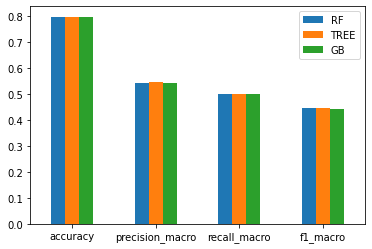

In [51]:
# Montando uma estrutura com os dados resultantes das médias calculadas pelo modelos classificadores para cada métrica
df_data_num = pd.DataFrame({'RF': avg_scores_rf, 'TREE': avg_scores_tree, 'GB': avg_scores_gb}, index=scoring_list)

ax = df_data_num.plot.bar(rot=0)

O gráfico mostra que na comparação entre os modelos avaliados, existe variações muito pequenas, quase insignificantes para cada métrica entre esses modelos.

### Consultando o nível de importância de cada atributo por cada modelo classificador

In [52]:
#RANDOM FOREST
clf_rf = RandomForestClassifier(n_estimators=300)
clf_rf = clf_rf.fit(X,y)

importance_rf = clf_rf.feature_importances_
importance_rf

array([0.89850255, 0.03790377, 0.01738001, 0.02274183, 0.02347184])

In [53]:
#TREE
clf_tree = DecisionTreeClassifier(criterion='entropy')
clf_tree = clf_tree.fit(X,y)

importance_tree = clf_tree.feature_importances_
importance_tree

array([0.71568874, 0.04594096, 0.0675513 , 0.08290625, 0.08791275])

In [54]:
#GRADIENTE BOOSTING
clf_gb = GradientBoostingClassifier(n_estimators=300)
clf_gb = clf_gb.fit(X,y)

importance_gb = clf_gb.feature_importances_
importance_gb

array([0.84891906, 0.03115181, 0.03294343, 0.04452156, 0.04246414])

###Selecionando as características mais importantes a partir dos modelos de classificação

[0]
[[62  1  0  0  0]]


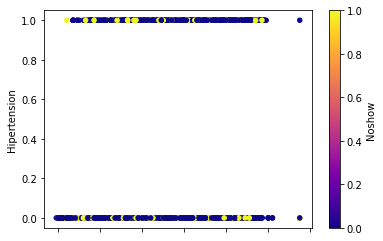

In [55]:
#RANDOM FOREST
model = SelectFromModel(clf_rf, prefit=True)
data_new = model.transform(X)

n_attrs = data_new.shape[1]
idx_most_important = importance_rf.argsort()[-n_attrs:]
print(idx_most_important)

name_important_attrs = np.array(X)[idx_most_important]
print(name_important_attrs)

ax = data_num.plot.scatter(x='Age',
                           y='Hipertension',
                           c='Noshow',
                           colormap='plasma')

[0]
[[62  1  0  0  0]]


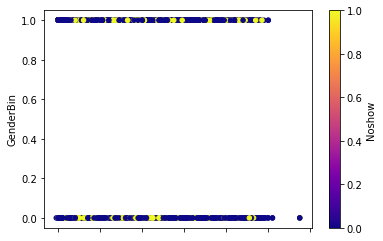

In [56]:
#DECISION TREE
model = SelectFromModel(clf_tree, prefit=True)
data_new = model.transform(X)

n_attrs = data_new.shape[1]
idx_most_important = importance_tree.argsort()[-n_attrs:]
print(idx_most_important)

name_important_attrs = np.array(X)[idx_most_important]
print(name_important_attrs)

ax = data_num.plot.scatter(x='Age',
                           y='GenderBin',
                           c='Noshow',
                           colormap='plasma')

[0]
[[62  1  0  0  0]]


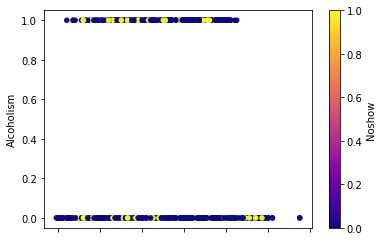

In [57]:
#GRADIENT BOOSTING
model = SelectFromModel(clf_gb, prefit=True)
data_new = model.transform(X)

n_attrs = data_new.shape[1]
idx_most_important = importance_gb.argsort()[-n_attrs:]
print(idx_most_important)

name_important_attrs = np.array(X)[idx_most_important]
print(name_important_attrs)

ax3 = data_num.plot.scatter(x='Age',
                           y='Alcoholism',
                           c='Noshow',
                           colormap='plasma')

Os gráficos de dispersão foram plotados seguindo o nível de importância/influência caracterizada pelos modelos classificadores Random Forest e Decision Tree. Ambos os modelos apresentam resultados muito semelhantes, mesmo sendo caracterizados de maneira própria de cada modelo. Além de existir um grau positivo de correlação entre os atributos.

###Reduzindo dimensionalidade usando PCA

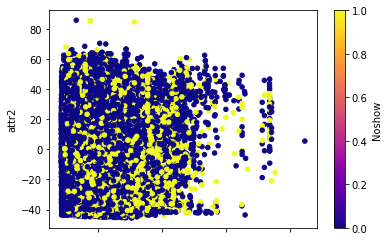

In [58]:
# Aplicando redução de dimensionalidade linear através do PCA
df_data_num = data_num.drop(['PatientId', 'ScheduledDay', 'AppointmentDay', 'Noshow'], axis=1).values
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_data_num)

pca_df_data_num = pd.DataFrame(data=principalComponents, 
                           columns = ['attr1', 'attr2'])

pca_df_data_num = pd.concat([pca_df_data_num, data_num['Noshow']], axis = 1)

ax2 = pca_df_data_num.plot.scatter(x='attr1',
                      y='attr2',
                      c='Noshow',
                      colormap='plasma')

O gráfico de dispersão acima mostra o resultado pós procedimento de redução de dimensionalidade por meio do PCA. Essa transformação reduziu os atributos correlacionados num conjunto de dados de apenas duas dimensões com os componentes principais.